## Feature Engineering 
Author: Anne Tumlin

Date: 04/05/25

Now that we have our baseline results, our goal is to perform feature engineering and hyperparameter tuning to improve our existing results. First, I will investigate feature engineering by checking various correlations. 

First, load in the dataset (via parquet file) for evaluation. 

In [1]:
import os
import subprocess
import time
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, explode, input_file_name, expr, sum as spark_sum, avg, count

spark = SparkSession.builder \
    .appName("app_name") \
    .getOrCreate()

In [3]:
start_time = time.time()

# df = spark.read.parquet("gs://bucketmilestonedonna/processed_data/agg_df.parquet")
df = spark.read.parquet("gs://ds5460-tumlinam-fp-bucket/processed_data/agg_df.parquet")

end_time = time.time()
print(f"Reading took {end_time - start_time:.2f} seconds")

Reading took 3.77 seconds


In [4]:
df.show(5) # verify loaded data

+--------------------+--------------+------------------+------+------------------+-----------------+------------------+---------+------------------+--------------------+--------------------+------------------+----------+----------+--------------------+-------------------+-----------------+------------------+------------------+
|            filename|num_generators|          total_pg|avg_vg|  avg_cost_squared|  avg_cost_linear|   avg_cost_offset|num_loads|          total_pd|           br_r_mean|           br_x_mean|        rate_a_sum|rate_b_min|rate_c_max|     trans_br_r_mean|    trans_br_x_mean| trans_rate_a_sum|          tap_mean|        total_cost|
+--------------------+--------------+------------------+------+------------------+-----------------+------------------+---------+------------------+--------------------+--------------------+------------------+----------+----------+--------------------+-------------------+-----------------+------------------+------------------+
|gs://ds5460-

Our `total_cost` depends on multiple system-wide parameters (generation, loads, rates, cost curves). So, to enhance our features we will refine them to create the new features for our model to utilize. 

In [5]:
from pyspark.sql.functions import col

df = df.withColumn("cost_per_gen", col("total_cost") / col("num_generators"))
df = df.withColumn("cost_per_mw", col("total_cost") / col("total_pg"))
df = df.withColumn("generation_margin", col("total_pg") - col("total_pd"))
df = df.withColumn("load_to_gen_ratio", col("total_pd") / col("total_pg"))
df = df.withColumn("trans_to_br_ratio_r", col("trans_br_r_mean") / col("br_r_mean"))
df = df.withColumn("trans_to_br_ratio_x", col("trans_br_x_mean") / col("br_x_mean"))
df = df.withColumn("trans_rate_ratio", col("trans_rate_a_sum") / col("rate_a_sum"))
df = df.withColumn("load_per_generator", col("num_loads") / col("num_generators"))
df = df.withColumn("pd_per_load", col("total_pd") / col("num_loads"))

In [6]:
df.show(5) # verify new features

+--------------------+--------------+------------------+------+------------------+-----------------+------------------+---------+------------------+--------------------+--------------------+------------------+----------+----------+--------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+
|            filename|num_generators|          total_pg|avg_vg|  avg_cost_squared|  avg_cost_linear|   avg_cost_offset|num_loads|          total_pd|           br_r_mean|           br_x_mean|        rate_a_sum|rate_b_min|rate_c_max|     trans_br_r_mean|    trans_br_x_mean| trans_rate_a_sum|          tap_mean|        total_cost|      cost_per_gen|       cost_per_mw|  generation_margin| load_to_gen_ratio|trans_to_br_ratio_r|trans_to_br_ratio_x|  trans_rate_ratio|load_per_generator|       pd_per_

In [ ]:
from pyspark.sql.functions import corr

feature_cols = [c for c in df.columns if c not in ['filename', 'total_cost']]

start_time = time.time()
correlations = []
for col_name in feature_cols:
    corr_value = df.select(corr(col_name, "total_cost").alias("corr")).collect()[0]["corr"]
    if corr_value is None:
        correlations.append((col_name, None))
    else:
        correlations.append((col_name, corr_value))

sorted_correlations = sorted(correlations, key=lambda x: abs(x[1]) if x[1] is not None else 0, reverse=True)

for feature, value in sorted_correlations:
    if value is not None:
        print(f"{feature:25} -> {value:.4f}")
    else:
        print(f"{feature:25} -> None (possibly constant)")
end_time = time.time() 
print(f"Correlation evaluation took {end_time - start_time:.2f} seconds")

cost_per_mw               -> 1.0000
cost_per_gen              -> 1.0000
total_pd                  -> 0.9990
pd_per_load               -> 0.9990
generation_margin         -> -0.9990
load_to_gen_ratio         -> 0.9990
trans_br_r_mean           -> -0.0125
num_generators            -> None (possibly constant)
total_pg                  -> None (possibly constant)
avg_vg                    -> None (possibly constant)
avg_cost_squared          -> None (possibly constant)
avg_cost_linear           -> None (possibly constant)
avg_cost_offset           -> None (possibly constant)
num_loads                 -> None (possibly constant)
br_r_mean                 -> None (possibly constant)
br_x_mean                 -> None (possibly constant)
rate_a_sum                -> None (possibly constant)
rate_b_min                -> None (possibly constant)
rate_c_max                -> None (possibly constant)
trans_br_x_mean           -> None (possibly constant)
trans_rate_a_sum          -> None (possibly 

A lot of our values are returning None which implies that our features are constant (since we already checked for Null values). Therefore, let's investigate further and potentially prune the features that provide no usefullness for modeling. 

In [9]:
from pyspark.sql.functions import countDistinct
# How many unique values are there per column?
for col_name in feature_cols:
    unique_vals = df.select(countDistinct(col_name)).collect()[0][0]
    print(f"{col_name:25} | Unique values: {unique_vals}")

num_generators            | Unique values: 1
total_pg                  | Unique values: 1
avg_vg                    | Unique values: 1
avg_cost_squared          | Unique values: 1
avg_cost_linear           | Unique values: 1
avg_cost_offset           | Unique values: 1
num_loads                 | Unique values: 1
total_pd                  | Unique values: 15000
br_r_mean                 | Unique values: 1
br_x_mean                 | Unique values: 1
rate_a_sum                | Unique values: 1
rate_b_min                | Unique values: 1
rate_c_max                | Unique values: 1
trans_br_r_mean           | Unique values: 1
trans_br_x_mean           | Unique values: 1
trans_rate_a_sum          | Unique values: 1
tap_mean                  | Unique values: 1
cost_per_gen              | Unique values: 15000
cost_per_mw               | Unique values: 15000
generation_margin         | Unique values: 15000
load_to_gen_ratio         | Unique values: 15000
trans_to_br_ratio_r       | Unique 

In [11]:
from pyspark.sql.functions import col, isnan, when, count
# Just to verify that there are no null values...
for col_name in feature_cols:
    nulls = df.select(count(when(col(col_name).isNull() | isnan(col(col_name)), col_name))).collect()[0][0]
    print(f"{col_name:25} | Null/NaN count: {nulls}")

num_generators            | Null/NaN count: 0
total_pg                  | Null/NaN count: 0
avg_vg                    | Null/NaN count: 0
avg_cost_squared          | Null/NaN count: 0
avg_cost_linear           | Null/NaN count: 0
avg_cost_offset           | Null/NaN count: 0
num_loads                 | Null/NaN count: 0
total_pd                  | Null/NaN count: 0
br_r_mean                 | Null/NaN count: 0
br_x_mean                 | Null/NaN count: 0
rate_a_sum                | Null/NaN count: 0
rate_b_min                | Null/NaN count: 0
rate_c_max                | Null/NaN count: 0
trans_br_r_mean           | Null/NaN count: 0
trans_br_x_mean           | Null/NaN count: 0
trans_rate_a_sum          | Null/NaN count: 0
tap_mean                  | Null/NaN count: 0
cost_per_gen              | Null/NaN count: 0
cost_per_mw               | Null/NaN count: 0
generation_margin         | Null/NaN count: 0
load_to_gen_ratio         | Null/NaN count: 0
trans_to_br_ratio_r       | Null/N

From the analysis above, we can see that a decent amount of our features columns are constant. However, none of our columns have Null/NaN values. Therefore, we will prune the columns which contain constants.  

In [ ]:
constant_cols = []

for col_name in feature_cols:
    unique_vals = df.select(countDistinct(col_name)).collect()[0][0]
    if unique_vals <= 1:
        constant_cols.append(col_name)

print("Dropping constant columns:", constant_cols)

# Drop them from the dataframe
df_cleaned = df.drop(*constant_cols)

Dropping constant columns: ['num_generators', 'total_pg', 'avg_vg', 'avg_cost_squared', 'avg_cost_linear', 'avg_cost_offset', 'num_loads', 'br_r_mean', 'br_x_mean', 'rate_a_sum', 'rate_b_min', 'rate_c_max', 'trans_br_r_mean', 'trans_br_x_mean', 'trans_rate_a_sum', 'tap_mean', 'trans_to_br_ratio_r', 'trans_to_br_ratio_x', 'trans_rate_ratio', 'load_per_generator']


In [13]:
df_cleaned.show(5)

+--------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|            filename|          total_pd|        total_cost|      cost_per_gen|       cost_per_mw|  generation_margin| load_to_gen_ratio|       pd_per_load|
+--------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|gs://ds5460-tumli...|178.07434280491296| 457017.6915453811|2672.6180792127548| 2964.789502387657|-23.925897804912978| 1.155213358168569|0.6337165224374126|
|gs://ds5460-tumli...|177.75404115936618|454991.87287162687| 2660.771186383783| 2951.647503623062|  -23.6055961593662|1.1531354802791958|0.6325766589301287|
|gs://ds5460-tumli...|176.44749746510547|448851.02127889916|2624.8597735608137| 2911.810244202588| -22.29905246510549|1.1446596004591905|0.6279270372423682|
|gs://ds5460-tumli...|179.48218836865323|463761.2446537249

Now that we have shrunk our feature space to non-constant features, let's analyze the data.

In [14]:
df_cleaned.select(
    "total_pd", "total_cost", "cost_per_gen", "cost_per_mw",
    "generation_margin", "load_to_gen_ratio", "pd_per_load"
).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show(truncate=False)

+-------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+
|summary|total_pd          |total_cost        |cost_per_gen      |cost_per_mw       |generation_margin  |load_to_gen_ratio  |pd_per_load         |
+-------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+
|count  |15000             |15000             |15000             |15000             |15000              |15000              |15000               |
|mean   |177.71919542785122|455058.1915002695 |2661.159014621464 |2952.0777293619167|-23.57075042785142 |1.1529094271943596 |0.6324526527681542  |
|stddev |1.425026235409197 |6803.242668321199 |39.785044843983606|44.13435807491406 |1.425026235409197  |0.00924450606951759|0.005071267741669744|
|min    |172.39261507968072|431924.47773403546|2525.8741387955292|2802.003469668705 |-29.115787346540202|1.11835455154

In [15]:
%matplotlib inline

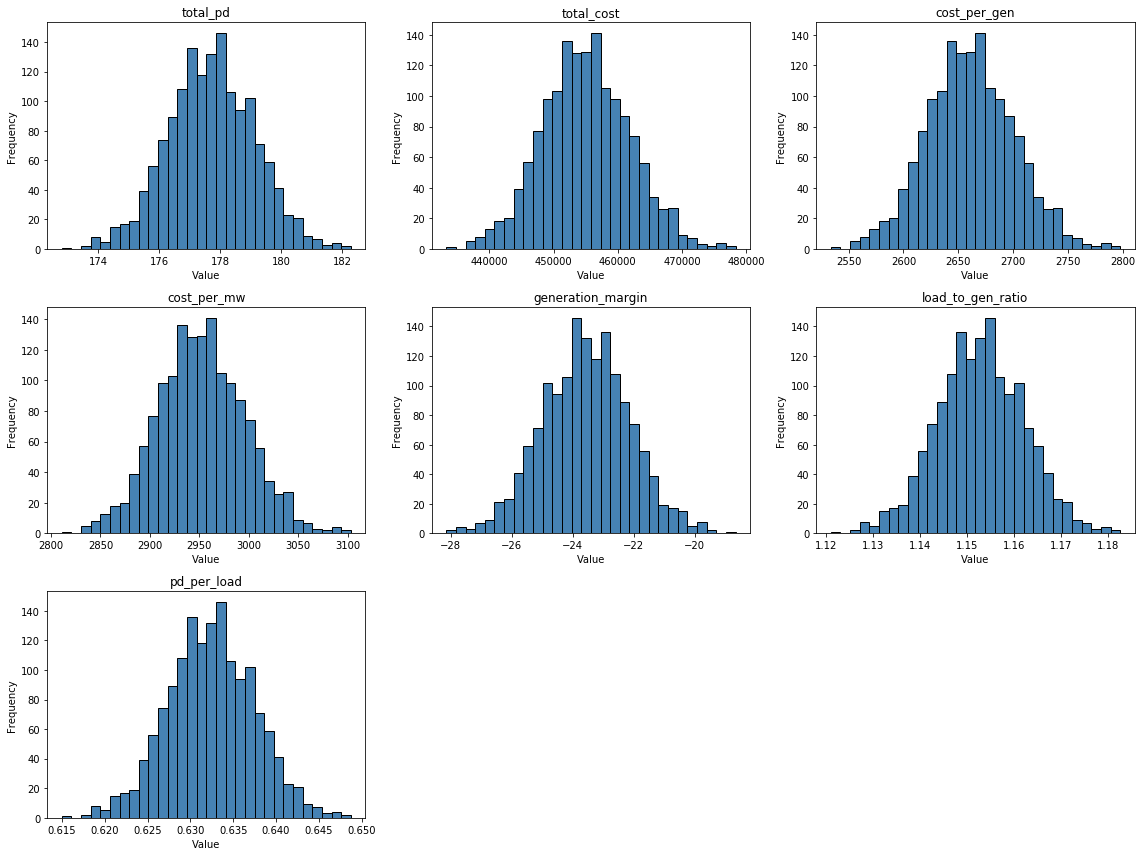

In [16]:
import matplotlib.pyplot as plt

features = [
    "total_pd", "total_cost", "cost_per_gen", "cost_per_mw",
    "generation_margin", "load_to_gen_ratio", "pd_per_load"
]

# Sample ~10% of data to speed things up
sample_df = df_cleaned.select(*features).sample(fraction=0.1, seed=42).dropna()
sample_pd = sample_df.toPandas()

# Plot
plt.figure(figsize=(16, 12))
for i, col_name in enumerate(features, 1):
    plt.subplot(3, 3, i)
    plt.hist(sample_pd[col_name], bins=30, color='steelblue', edgecolor='black')
    plt.title(col_name)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Edits: 04/07/25**

Upon doing some further analysis on the dataset, we have found that in general our feature space is highly correlated and does not provide much nuance for our model to train and find correlations to the total cost. Our data is based upon generation, load, transformer, and AC power lines. When performing analysis, we found that there are many constant features (which are not none or null). This is due to the fact that for each input grid the generation, ac lines, and transformer features are kept the same. The load features of the grid are what are varied and what to lead to differences in predictions. This makes sense as the dataset is synthetically generated. Therefore, I am going to look at doing some feature engineering specifically in regards to the load features. 

### Load Feature Engineering 

In [18]:
# Start by reading in the non-aggregated data 
df = spark.read.parquet("gs://ds5460-tumlinam-fp-bucket/opf_data_parquet/")
df.count(), len(df_parquet.columns)

(15000, 4)

In [19]:
from pyspark.sql.functions import explode, col, count, sum as spark_sum, avg, stddev, max, min, expr

load_df = df.select(
    "filename",
    explode("grid.nodes.load").alias("load_array")
).select(
    "filename",
    col("load_array")[0].alias("pd"),
    col("load_array")[1].alias("qd")
)
load_df.show(5)

+--------------------+-------------------+--------------------+
|            filename|                 pd|                  qd|
+--------------------+-------------------+--------------------+
|gs://ds5460-tumli...|0.28673451151559004| 0.06606636299808374|
|gs://ds5460-tumli...| 1.1682192385751553|  0.2286088931026518|
|gs://ds5460-tumli...|0.47305084490987326|  0.1108576311506781|
|gs://ds5460-tumli...| 0.7376655330764088|0.040399505505900886|
|gs://ds5460-tumli...| 0.8973411417881758|  0.1582530803391884|
+--------------------+-------------------+--------------------+
only showing top 5 rows



In [22]:
# Aggregate load features
load_agg = load_df.groupBy("filename").agg(
    count("*").alias("num_loads"),
    spark_sum("pd").alias("total_pd"),
    avg("pd").alias("avg_pd"),
    stddev("pd").alias("std_pd"),
    max("pd").alias("max_pd"),
    min("pd").alias("min_pd"),
    expr("max(pd) - min(pd)").alias("pd_range"),

    spark_sum("qd").alias("total_qd"),
    avg("qd").alias("avg_qd"),
    stddev("qd").alias("std_qd")
)
load_agg.show(5)

+--------------------+---------+------------------+------------------+-------------------+------------------+--------------------+------------------+------------------+-------------------+-------------------+
|            filename|num_loads|          total_pd|            avg_pd|             std_pd|            max_pd|              min_pd|          pd_range|          total_qd|             avg_qd|             std_qd|
+--------------------+---------+------------------+------------------+-------------------+------------------+--------------------+------------------+------------------+-------------------+-------------------+
|gs://ds5460-tumli...|      281|178.03694880523543|0.6335834477054642| 0.4019725630211349|3.5419424350275617|8.041440267559536E-4| 3.541138291000806|45.820161104311175|0.16306107154559138|0.14294399920458845|
|gs://ds5460-tumli...|      281|177.34560942684104|0.6311231652200748|0.39949501211903493|3.5886751942556323|8.738419650607778E-4|3.5878013522905716|46.127842196081

**Explanation of Aggregated Features:**

total_pd: Total system active power demand — primary driver of generation cost; more demand typically increases dispatch cost.

avg_pd: Average demand per load node — helps normalize demand across differently sized systems and reflects overall load distribution.

std_pd: Standard deviation of active power demand — captures how unevenly demand is distributed across the system; higher values may suggest load imbalances or localized stress.

max_pd: Maximum single load value — indicates the presence of large, possibly industrial, loads that may drive localized grid constraints.

min_pd: Minimum single load value — provides context for load disparity and helps define the overall load range.

pd_range: Difference between maximum and minimum load (max_pd - min_pd) — quantifies load disparity, which may affect dispatch strategy or network congestion.

num_loads: Total number of load nodes — proxy for system size and granularity; systems with more loads may be more complex or realistic.

total_qd: Total system reactive power demand — contributes to voltage control requirements and can influence the use of generators or transformers for VAR support.

avg_qd: Average reactive demand per load node — gives insight into how much reactive power is needed per location; helps in understanding voltage regulation needs.

std_qd: Standard deviation of reactive demand — variability in qd can stress parts of the network and impact voltage stability.

**Let's evaluate how newly aggregated load features perform on a simple linear regression model.**

In [23]:
from pyspark.sql.functions import col

target_df = df.select("filename", col("metadata.objective").alias("total_cost")) # get objective = total cost

model_df = load_agg.join(target_df, on="filename", how="inner") # join dataframes together

In [24]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [c for c in model_df.columns if c != "filename" and c != "total_cost"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(model_df).select("features", "total_cost")

In [25]:
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.regression import LinearRegression
start_time = time.time()
lr = LinearRegression(featuresCol="features", labelCol="total_cost")
lr_model = lr.fit(train_df)
end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds")

Training took 310.83 seconds


In [29]:
predictions = lr_model.transform(test_df)
predictions.select("total_cost", "prediction").show(5)

# Print evaluation metrics
training_summary = lr_model.summary
print(f"RMSE: {training_summary.rootMeanSquaredError}")
print(f"R2: {training_summary.r2}")

+------------------+------------------+
|        total_cost|        prediction|
+------------------+------------------+
|441222.59195533436|441303.95750974386|
|443197.46306130086| 442921.1540644871|
| 443435.1858361645|  443506.459950762|
| 448868.3027144485| 448868.0070028816|
| 449576.6898633523|449658.62732984056|
+------------------+------------------+
only showing top 5 rows

RMSE: 291.4842795828821
R2: 0.9981641084678126


The load features perform fairly well with a simple linear regression model. It performs similar to our baselines with a RMSE around 291.5. This means our model is on average making mistakes in predictions around 300 dollars. Our R^2 value is very close to 1 which says that our model is predicting well. So, the additional load features are performing well. But can we make it better?

**Add more nunance to load features**

To improve our model, let's create more nuanced load features. Specifically, let's try to encode some overarching grid information through our load features which can have impacts on costs in the grid. 

In [31]:
from pyspark.sql.functions import expr

load_features_extended = load_agg.withColumn("pd_per_load", expr("total_pd / num_loads")) \
    .withColumn("load_concentration", expr("max_pd / total_pd")) \
    .withColumn("load_skew", expr("max_pd / avg_pd")) \
    .withColumn("load_range", expr("max_pd - min_pd")) \
    .withColumn("load_variability", expr("std_pd / avg_pd")) \
    .withColumn("reactive_ratio", expr("total_qd / total_pd"))
load_features_extended.show(5)

+--------------------+---------+------------------+------------------+-------------------+------------------+--------------------+------------------+------------------+-------------------+-------------------+------------------+--------------------+-----------------+------------------+------------------+-------------------+
|            filename|num_loads|          total_pd|            avg_pd|             std_pd|            max_pd|              min_pd|          pd_range|          total_qd|             avg_qd|             std_qd|       pd_per_load|  load_concentration|        load_skew|        load_range|  load_variability|     reactive_ratio|
+--------------------+---------+------------------+------------------+-------------------+------------------+--------------------+------------------+------------------+-------------------+-------------------+------------------+--------------------+-----------------+------------------+------------------+-------------------+
|gs://ds5460-tumli...|   

**More Features Explanation**

pd_per_load: Average active power demand per load node — helps normalize total demand across systems of different sizes; indicates average burden per node.

load_concentration: Ratio of the largest load to total system demand (max_pd / total_pd) — captures whether one load dominates the system, which could cause local stress and increase cost.

load_skew: Ratio of the largest load to the average load (max_pd / avg_pd) — highlights imbalance in the load distribution; higher values may imply difficult-to-serve systems.

load_range: Difference between the maximum and minimum load (max_pd - min_pd) — quantifies the spread in demand across the system; a proxy for diversity in load magnitudes.

load_variability: Relative standard deviation of loads (std_pd / avg_pd) — measures how unevenly demand is distributed; higher values may result in inefficient or expensive dispatch.

reactive_ratio: Ratio of total reactive to active power (total_qd / total_pd) — represents the system's VAR burden; high values can signal voltage control challenges and possible transformer/generator stress.

In [36]:
load_features_extended_with_cost = load_features_extended.join(target_df, on="filename", how="inner")

In [37]:
load_features_extended_with_cost.columns

['filename',
 'num_loads',
 'total_pd',
 'avg_pd',
 'std_pd',
 'max_pd',
 'min_pd',
 'pd_range',
 'total_qd',
 'avg_qd',
 'std_qd',
 'pd_per_load',
 'load_concentration',
 'load_skew',
 'load_range',
 'load_variability',
 'reactive_ratio',
 'total_cost']

In [39]:
load_features_extended_with_cost.write.mode("overwrite").parquet(
    "gs://ds5460-tumlinam-fp-bucket/final_datasets/load_features_extended_with_cost/"
)
print("Done.")

Done.


In [ ]:
feature_cols = [c for c in load_features_extended_with_cost.columns if c not in ['filename', 'total_cost']]

start_time = time.time()
correlations = []
for col_name in feature_cols:
    corr_value = load_features_extended_with_cost.select(corr(col_name, "total_cost").alias("corr")).collect()[0]["corr"]
    if corr_value is None:
        correlations.append((col_name, None))
    else:
        correlations.append((col_name, corr_value))

sorted_correlations = sorted(correlations, key=lambda x: abs(x[1]) if x[1] is not None else 0, reverse=True)

for feature, value in sorted_correlations:
    if value is not None:
        print(f"{feature:25} -> {value:.4f}")
    else:
        print(f"{feature:25} -> None (possibly constant)")
end_time = time.time() 
print(f"Correlation evaluation took {end_time - start_time:.2f} seconds")

total_pd                  -> 0.9990
avg_pd                    -> 0.9990
pd_per_load               -> 0.9990
reactive_ratio            -> -0.6665
std_pd                    -> 0.6223
load_variability          -> 0.3792
pd_range                  -> 0.2368
load_range                -> 0.2368
max_pd                    -> 0.2368
load_concentration        -> 0.1699
load_skew                 -> 0.1699
min_pd                    -> -0.0073
std_qd                    -> -0.0067
avg_qd                    -> -0.0027
total_qd                  -> -0.0027
num_loads                 -> None (possibly constant)
Correlation evaluation took 1219.44 seconds


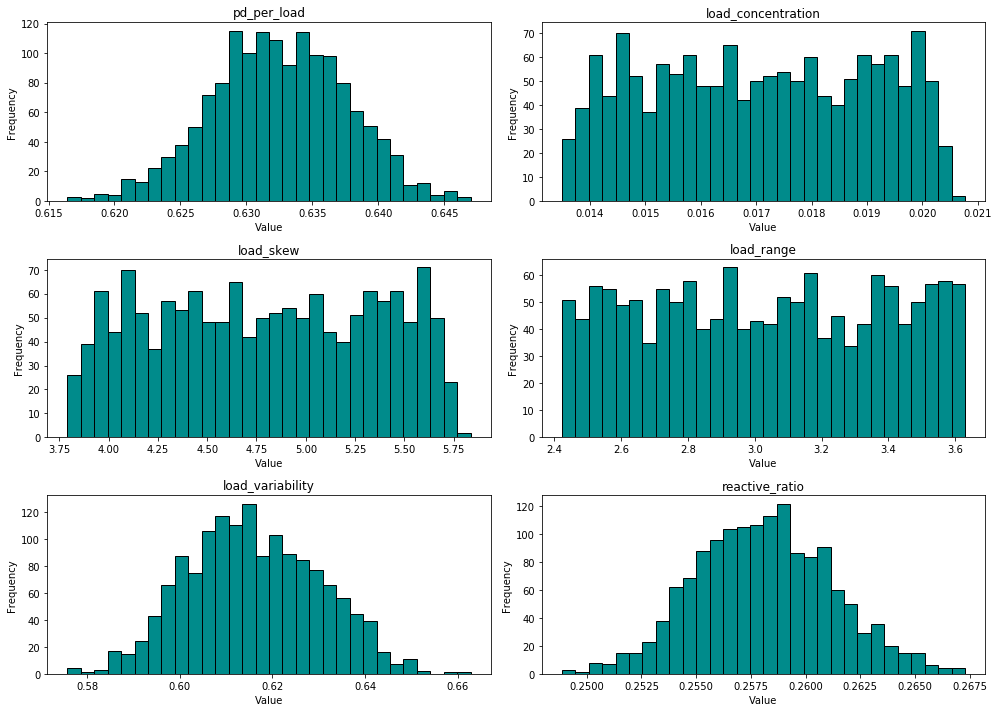

In [41]:
engineered_features = [
    "pd_per_load",
    "load_concentration",
    "load_skew",
    "load_range",
    "load_variability",
    "reactive_ratio"
]

# Sample ~10% of data
sample_df = load_features_extended_with_cost.select(*engineered_features).sample(fraction=0.1, seed=42).dropna()
sample_pd = sample_df.toPandas()

# Plot histograms
plt.figure(figsize=(14, 10))
for i, col_name in enumerate(engineered_features, 1):
    plt.subplot(3, 2, i)
    plt.hist(sample_pd[col_name], bins=30, color='darkcyan', edgecolor='black')
    plt.title(col_name)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Now let's add the informative load features with the cleaned features from earlier to get our final feature dataset. 

In [ ]:
# Select the expressive subset from df_cleaned
expressive_df = df_cleaned.select(
    "filename", "generation_margin", "load_to_gen_ratio"
)

# Select strong load-based features
top_load_features = [
    "filename", "total_cost", "avg_pd", "pd_per_load", "reactive_ratio", "std_pd",
    "load_variability", "pd_range", "load_range", "max_pd", "load_concentration", "load_skew"
]

load_subset = load_features_extended_with_cost.select(*top_load_features)

# Join on filename
combined_features_df = load_subset.join(expressive_df, on="filename", how="inner")
combined_features_df.show(5)

+--------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+-------------------+------------------+
|            filename|        total_cost|            avg_pd|       pd_per_load|     reactive_ratio|             std_pd|  load_variability|          pd_range|        load_range|            max_pd|  load_concentration|        load_skew|  generation_margin| load_to_gen_ratio|
+--------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+-------------------+------------------+
|gs://ds5460-tumli...| 450649.8969254288|0.6288539760583007|0.6288539760583007| 0.2585331757467569|0.38051412452406946|0.6050913868894616| 2.895029383844323| 2.895029383844323| 2

In [54]:
combined_features_df.write.mode("overwrite").parquet(
    "gs://ds5460-tumlinam-fp-bucket/final_datasets/combined_features_df/"
)
print("Done.")

Done.


### Important - Load in New Features for Hyperparamater Tuning

Make sure to save parquet file and then utilize it for the hyperparameter tuning below. 

In [55]:
df = spark.read.parquet("gs://ds5460-tumlinam-fp-bucket/final_datasets/combined_features_df/")
df.show(5)

+--------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+-------------------+------------------+
|            filename|        total_cost|            avg_pd|       pd_per_load|     reactive_ratio|             std_pd|  load_variability|          pd_range|        load_range|            max_pd|  load_concentration|        load_skew|  generation_margin| load_to_gen_ratio|
+--------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+-------------------+------------------+
|gs://ds5460-tumli...| 457017.6915453811|0.6337165224374126|0.6337165224374126|0.25578066583740294| 0.3907887552662506| 0.616661774515822| 2.895855111560307| 2.895855111560307| 2

**How well does a simple LR train with our features now?**

In [56]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [c for c in df.columns if c != "filename" and c != "total_cost"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df).select("features", "total_cost")

In [57]:
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.regression import LinearRegression
start_time = time.time()
lr = LinearRegression(featuresCol="features", labelCol="total_cost")
lr_model = lr.fit(train_df)
end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds")

In [52]:
predictions = lr_model.transform(test_df)
predictions.select("total_cost", "prediction").show(5)

# Print evaluation metrics
training_summary = lr_model.summary
print(f"RMSE: {training_summary.rootMeanSquaredError}")
print(f"R2: {training_summary.r2}")

+------------------+------------------+
|        total_cost|        prediction|
+------------------+------------------+
|436232.22792202106| 436232.3859864974|
| 436047.0847022127|436047.87792709924|
| 437148.8297860676| 437148.8659926856|
| 438577.7912702936|438578.11193344736|
| 438320.2088231557| 438320.7676423446|
+------------------+------------------+
only showing top 5 rows

RMSE: 0.18466410159264585
R2: 0.999999999261073


## Hyperparameter Tuning
Author: Ewan Long

Date: 04/03/25

Edit Date: 04/06/25

To perform hyperparameter tuning on the dataset with the new features, explore and improve our linear regression model, we use both L1 and L2 regularization (Elastic Net Regularization), then use a parameter grid to explore various values for the regularization parameters.

To speed up the tuning process, we first run a 3-fold cross-validation on a 10% sample of our dataset. The experiments include the following hyperparameter settings:

- regParam: 0.01, 0.1, 0.5
- elasticNetParam: 
  - 0.0 (pure L2 regularization)
  - 0.5 (mixed regularization)
  - 1.0 (pure L1 regularization)

Firstly, we choose the feature columns that Anne picked, exluding `filename` and using `total_cost` as the label, and create VectorAssembler to combine all feature columns, which is then used as the input for the regression model.

In [19]:
# Import Libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [20]:
feature_cols = ["total_pd", "cost_per_gen", "cost_per_mw", 
                "generation_margin", "load_to_gen_ratio", "pd_per_load"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

lr = LinearRegression(featuresCol="features", labelCol="total_cost")

pipeline = Pipeline(stages=[assembler, lr])

Then, define the hyperparameter grid to explore.

In [21]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Set up the Regression Evaluator using RMSE as the evaluation metric
evaluator = RegressionEvaluator(labelCol="total_cost", predictionCol="prediction", metricName="rmse")

We will only pick a sample of 10% subset of the cleaned dataset for faster tuning.

In [22]:
df_subset = df_cleaned.sample(fraction=0.1, seed=42)

# Set up CrossValidator with 3-fold cross-validation
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)


In [23]:
# Fit the CrossValidator on the subset of data
cvModel = cv.fit(df_subset)

# Retrieve the best model and its linear regression stage
bestModel = cvModel.bestModel
best_lr = bestModel.stages[-1]

print("Best model parameters:")
print("  regParam:", best_lr._java_obj.getRegParam())
print("  elasticNetParam:", best_lr._java_obj.getElasticNetParam())

25/04/07 04:10:36 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
25/04/07 04:10:38 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
25/04/07 04:11:19 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
25/04/07 04:11:19 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


Best model parameters:
  regParam: 0.1
  elasticNetParam: 1.0


In [24]:
# Evaluate the best model on the subset using RMSE
rmse = evaluator.evaluate(bestModel.transform(df_subset))
print("RMSE on the subset:", rmse)

RMSE on the subset: 0.1000331825546619


Create a heatmap for quckly comparing the performance.

In [25]:
import numpy as np

regParam_values = [0.01, 0.1, 0.5]
elasticNetParam_values = [0.0, 0.5, 1.0]

avg_metrics = cvModel.avgMetrics  # This should be a list with 9 entries

rmse_matrix = np.array(avg_metrics).reshape(len(regParam_values), len(elasticNetParam_values))

rmse_matrix = rmse_matrix.T

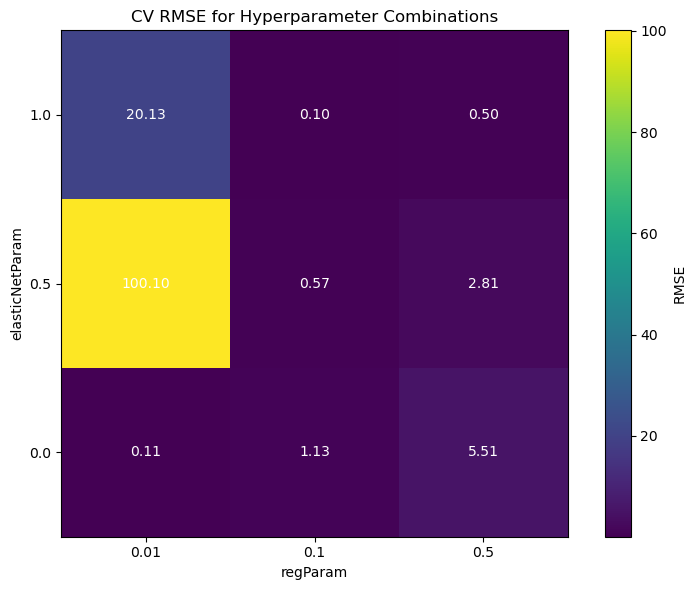

In [26]:
# Create a heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(rmse_matrix, cmap='viridis', origin='lower')

# Set axis tick labels
plt.xticks(np.arange(len(regParam_values)), regParam_values)
plt.yticks(np.arange(len(elasticNetParam_values)), elasticNetParam_values)

# Add labels and title
plt.xlabel('regParam')
plt.ylabel('elasticNetParam')
plt.title('CV RMSE for Hyperparameter Combinations')

# Add a colorbar to represent the RMSE values
cbar = plt.colorbar(im)
cbar.set_label('RMSE')

# Annotate each cell with the RMSE value
for i in range(len(elasticNetParam_values)):
    for j in range(len(regParam_values)):
        plt.text(j, i, f"{rmse_matrix[i, j]:.2f}", ha="center", va="center", color="white")

plt.tight_layout()
plt.show()


Based on the result, we can find that the lowest RMSE is 0.10 at `regParam = 0.1` and `elasticNetParam = 1.0`, which is the pure L1 regularization.
  
`regParam = 0.01` and `elasticNetParam = 0.5` has a very high RMSE of 100.10, likely beacuse of under-regularization.
  
`regParam = 0.01` and `elasticNetParam = 1.0` also performs poorly which's RMSE = 20.13.
  
Overall, `regParam = 0.1` and `elasticNetParam = 1.0` is the best configuration option, and avoid using very low `regParam` values like 0.01, especially with L1 or mixed regularization, which is unstable or overfitted.

## Hyperparameter Tuning (Different model)
Author: Donna Nguyen

Date: 04/7/25

I will perform hyperparameter tuning on a different model than the linear regression from milestone 2 (still using paramGrid but with RandomForestRegressor.)

In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Spark session already initialized earlier as `spark`
# Using your cleaned dataset
df_model = df_cleaned.select(*[c for c in df_cleaned.columns if c != "filename"])

# Assemble features into a single vector
feature_cols = [col for col in df_model.columns if col != "total_cost"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_model = assembler.transform(df_model).select("features", "total_cost")

# Optional: sample to speed up testing
df_sampled = df_model.sample(fraction=0.1, seed=42)  # adjust fraction as needed

# Split into train/test
train_data, test_data = df_sampled.randomSplit([0.8, 0.2], seed=42)

# Define the regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="total_cost")




In [ ]:
# Hyperparameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 15])
             .addGrid(rf.numTrees, [20, 50, 100])
             .addGrid(rf.maxBins, [32, 64])
             .build())

# Evaluator for regression
evaluator = RegressionEvaluator(labelCol="total_cost", predictionCol="prediction", metricName="rmse")

# CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=2)  # Adjust based on cluster resources

# Train the model
cv_model = crossval.fit(train_data)

# Evaluate on test data
predictions = cv_model.transform(test_data)
rmse = evaluator.evaluate(predictions)
print(f"Test RMSE: {rmse:.4f}")

# Best model hyperparameters
best_model = cv_model.bestModel
print(f"Best Max Depth: {best_model.getOrDefault('maxDepth')}")
print(f"Best Num Trees: {best_model.getOrDefault('numTrees')}")
print(f"Best Max Bins: {best_model.getOrDefault('maxBins')}")



Test RMSE: 480.7272
Best Max Depth: 15
Best Num Trees: 20
Best Max Bins: 64


In [10]:
# Show predictions
predictions.select("features", "total_cost", "prediction").show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------+------------------+------------------+
|features                                                                                                          |total_cost        |prediction        |
+------------------------------------------------------------------------------------------------------------------+------------------+------------------+
|[173.9776445666882,2560.48586699376,2840.398962545052,-19.82919956668823,1.1286370392298686,0.6191375251483566]   |437843.08325593296|438939.74430452735|
|[174.0334151565635,2561.847094972967,2841.9090003819206,-19.884970156563526,1.1289988371699988,0.6193359969984467]|438075.8532403774 |438939.74430452735|
|[174.4779280015317,2575.028000256443,2856.530846249223,-20.329483001531713,1.1318825045658536,0.620917893243885]  |440329.7880438518 |438939.74430452735|
|[175.43469617533097,2599.839171318905,2884.0543820959906,-21.28625117